## Classification of Speech Frames
PART IV: RECOGNIZE A PHONEME FROM FILTERBANK FEATURES WITH A DNN

In [1]:
%matplotlib inline
import io, os, sys
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
import torch
from scipy.fftpack import dct
import requests
import importlib
import scipy.io as sio
import urllib.request
import pickle
import gzip
#from IPython.display import display

# reproducibility 
torch.manual_seed(0) 
np.random.seed(0)

# pyspch
try:
  import google.colab
  IN_COLAB = True
  ! pip install git+https://github.com/compi1234/pyspch.git@v0.6
except:
  IN_COLAB = False

# pyspch
import pyspch
import pyspch.nn
logging.basicConfig(level=logging.INFO)

In [2]:
#@title Auxiliary functions 



# download from url and write to file
def write_from_url(url, filename):
    r = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(r.content)

# dictionairy
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
def dict_from_module(module):
    context = {}
    for setting in dir(module):
        # you can write your filter here
        if not setting.startswith('_'):
            context[setting] = getattr(module, setting)

    return context

# import setup file (.py) as module (dotdict)
def read_setup(filename, new_read_path=None, old_read_path='/users/spraak/spchlab/public_html/data/timit/'):
    
    # load module
    spec = importlib.util.spec_from_file_location(os.path.basename(filename), filename)
    setup = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(setup)
    
    # convert to dict 
    setup = dict_from_module(setup)
    setup = dotdict(setup)

    # replace esat_path with root_url
    if new_read_path is not None:
        for k, v in setup.items():
            if type(v) == str:
                setup[k] = v.replace(old_read_path, new_read_path)
            
    return setup

In [3]:
# device
use_cuda_if_available = True
if use_cuda_if_available:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
else:
    device = "cpu"
    
# root url
root_url = 'https://homes.esat.kuleuven.be/~spchlab/data/timit/'    

### Define Target Feature Extraction

In [6]:
feature_args = {'spg': None,  # tells feature extraction to start from wav files
 'Deltas': 'delta_delta2',
 'Norm': 'meanvar',
 'sample_rate': 16000,
 'f_shift': 0.01,
 'f_length': 0.03,
 'preemp': 0.97,
 'window': 'hamm',
 'mode': 'dB',
 'n_mels': 24,
 'n_cep': 13}

classes = pyspch.timit.get_timit_alphabet('timit41')
lab2classes = pyspch.timit.get_timit_mapping('timit61_timit41') 

### Define all datasets to work with and location on disk or (precomputed) feature files, segmentations, phonetic alphabet ..

In [7]:
corpus_path = 'https://homes.esat.kuleuven.be/~spchlab/data/timit/conf/'
train_corpus_file = corpus_path + 'timit_train.corpus'
test_corpus_file = corpus_path + 'timit_test.corpus'

feature_path = 'https://homes.esat.kuleuven.be/~spchlab/data/timit/features/mfcc13/'
train_pickle_file = feature_path + 'train.pkl'
test_pickle_file = feature_path + 'test.pkl'

In [8]:
# Prepare train set 



# corpus
train_corpus = pyspch.read_txt(train_corpus_file)

# read features 
train_df = pd.read_pickle(train_pickle_file)
train_data = pyspch.core.DataFrame_to_SpchData(train_df, delete_df=True) 
train_data = train_data.subset(train_corpus) 

# modify features in corpus

#train_data.modify_features(modify_feature_args) 
#train_data.modify_labels(lab2lab) # timit61 -> timit41

# Prepare test set (evaluation)

# corpus
test_corpus = pyspch.read_txt(test_corpus_file)

# read features 
test_df = pd.read_pickle(test_pickle_file)
test_data = pyspch.core.DataFrame_to_SpchData(test_df, delete_df=True) 
test_data = test_data.subset(test_corpus) 

# modify features in corpus

#test_data.modify_features(modify_feature_args) 
#test_data.modify_labels(lab2lab) # timit61 -> timit41

In [9]:
# feature arguments
read_feature_args = pyspch.read_json(feature_path + 'feature_args.json')
modify_feature_args = pyspch.dct_diff(read_feature_args, feature_args)
print(modify_feature_args)

{'Norm': 'meanvar', 'Deltas': 'delta_delta2'}


In [10]:
train_data.modify_features(modify_feature_args) 
train_data.modify_labels(lab2classes) # timit61 -> timit41
test_data.modify_features(modify_feature_args) 
test_data.modify_labels(lab2classes) # timit61 -> timit41

In [11]:
train_data.__dict__.keys()

dict_keys(['corpus', 'signals', 'features', 'labels', 'lengths', 'write_fnc', 'read_fnc'])

In [14]:
# Prepare GMM data

# input features
gmm_train_X = train_data.get_features_as_numpy() 
gmm_test_X = test_data.get_features_as_numpy() 

# labels
train_y = train_data.get_labels_as_numpy()
test_y = test_data.get_labels_as_numpy() 

In [12]:
#@title GMM functions

from pyspch.stats import GMM
from sklearn import metrics as skmetrics 

# =============================================================================
# GMM
# =============================================================================
def train_GMM(X_train, y_train,  classes, 
                n_components=1, max_iter=20, tol=1.e-3,
                print_result=True):
    clf_GMM = GMM(n_components, classes, max_iter, tol)
    clf_GMM.fit(X_train,y_train)
    if(print_result):
        y_pred = clf_GMM.predict(X_train)
        acc_train = 100.0*skmetrics.accuracy_score(y_train, y_pred)
        lls, bics = llscore(clf_GMM,X_train,y_train)
        print('Training Set:  Accuracy = %.2f%%     LL = %.2f    BIC = %.2f ' % (acc_train,lls,bics) )
    return(clf_GMM)
    
def test_GMM(X_test, y_test, clf_GMM , priors=None,
                   print_result=True, figsize=(20,20), norm=False, print_cmat=False):

    y_pred = clf_GMM.predict(X_test,priors=priors)
    acc_test = 100.0*skmetrics.accuracy_score(y_test, y_pred) 
    cmat = skmetrics.confusion_matrix(y_test,y_pred)
    if norm: 
        cmat = cmat / cmat.sum(axis=1)[:,None] 
        fmt = '.2f'
    else:
        fmt = 'd'
    if(print_result):
        print('Test Set:      Accuracy = %.2f%%'  % (acc_test) )
    if(print_cmat):
        pyspch.plot_confusion_matrix(cmat,labels=clf_GMM.classes,figsize=figsize,fmt=fmt)


def train_test_GMM(X_train, X_test, y_train, y_test, classes, 
                   n_components=1, max_iter=20, tol=1.e-3,
                   print_result=True, print_cmat=False):
    clf_GM = GaussianMixtureClf(n_components, classes, max_iter, tol)
    clf_GM.fit(X_train,y_train)
    y_pred = clf_GM.predict(X_train)
    acc_train = 100.0*skmetrics.accuracy_score(y_train, y_pred)
    y_pred = clf_GM.predict(X_test)
    acc_test = 100.0*skmetrics.accuracy_score(y_test, y_pred) 
    cmat = skmetrics.confusion_matrix(y_test,y_pred)
    if(print_result):
        lls, bics = llscore(clf_GM,X_train,y_train)
        print('Training Set:  Accuracy = %.2f%%     LL = %.2f    BIC = %.2f ' % (acc_train,lls,bics) )
        print('Test Set:      Accuracy = %.2f%%'  % (acc_test) )
    if(print_cmat):
        pyspch.plot_confusion_matrix(cmat, labels=classes)
    return (acc_test,acc_train)

def llscore(GMM,X,y):
    ''' Average log likelihood per sample over the full data set (X,y) 
    and BIC per sample '''
    ll = 0.
    for k in range(0,GMM.n_classes) :
        ll += GMM.gmm[k].score(X[y== GMM.classes[k],: ])
    lls = ll.mean()
    nparam = ((2*n_dim+1)*n_components -1 ) * GMM.n_classes
    bics = -2*lls + (np.log(X.shape[0])* nparam) / float(X.shape[0])
    return(lls,bics)

In [15]:
# GMM model
n_dim = gmm_train_X.shape[1] # feature dimension
n_components = 1 # number guassians, time = {8: 2min, 16: 3min, 32: 6min, 64: 12min}
max_iter = 2 # max number EM iterations
tolerance = 0.001 # tolerance (determines convergence)

print("*** n_components=%d ***" % (n_components))
#_,_ = train_test_GMM(gmm_train_X, gmm_test_X, train_y, test_y, classes=labels,
#                     n_components=n_components, max_iter=max_iter, tol=tolerance,
#                     print_result=True, print_cmat=True)

clf_GMM = train_GMM(gmm_train_X, train_y,  classes=classes,
                    n_components=n_components, max_iter=max_iter, tol=tolerance)

*** n_components=1 ***


C:\Users\dirk\Anaconda3\envs\py37_torch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  "KMeans is known to have a memory leak on Windows "


Training Set:  Accuracy = 45.50%     LL = -2092.83    BIC = 4185.69 


Test Set:      Accuracy = 44.94%


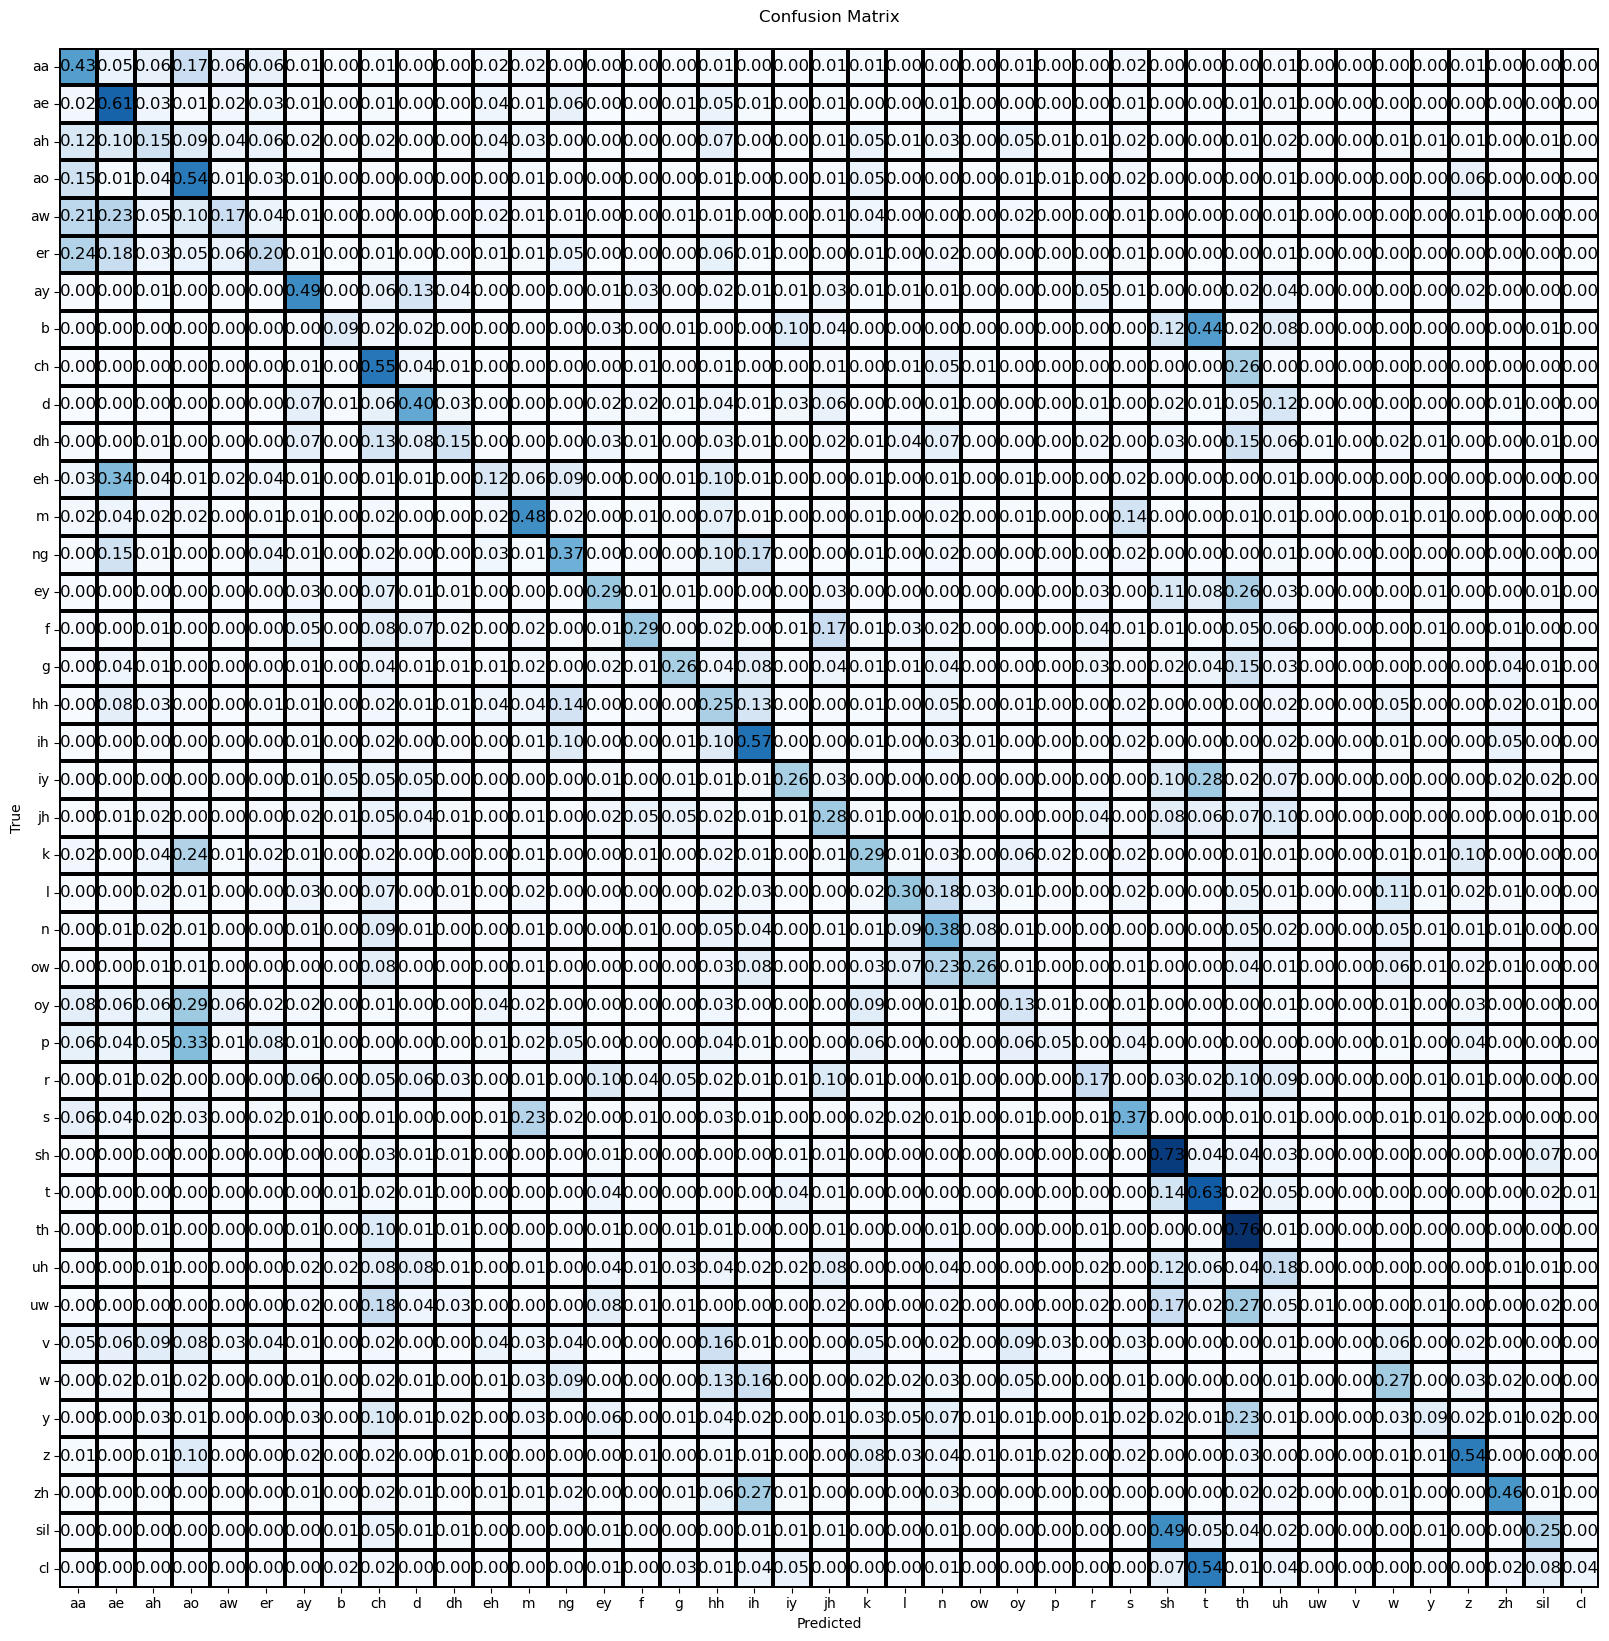

In [16]:
test_GMM(gmm_test_X, test_y, clf_GMM, print_result=True, print_cmat=True, norm=True, priors=None)

### Baseline DNN model

We use a simple Neural Network (NN) to classify the frames, namely a fully connected feed-forward network, with a sigmoid activation function following each hidden layer. The architecture is defined by the input, output and hidden layer sizes. 

The input feature is a window of 11 frames (black) around the target frame (red) with a stride of 2, giving window that spans 210 ms. 
The stride is distance (in time steps) between the selected frames. 
For each target frames, the selected frames are concatenated into a vector.
Alternatively, one could preserve the 2D structure of the input (time x frequency) provided the neural architecture allows it (e.g. using 2D convolutional layers). 

The phone labels are one-hot encoded, we thus have a neuron for each phone label in the output layer of the network. By applying the softmax function at the end of the network, we obtain phone probabilities as outputs. The predicted label is the one with the highest probabilty. 

Note that training a model from scratch on TIMIT is (relatively) computationally expensive. That is why we load a pretrained model, matching the architecture described above.

<img src="http://homes.esat.kuleuven.be/~spchlab/data_old/timit/dnn_setup_3.PNG" width="750">

#### Setup for baseline

In [ ]:
# baseline
# = mfcc13, delta_delta2, meanvar, 11 frames, stride 2
baseline_path = 'models/default/mfcc13dd2mv/N5s2/' 

# read setup A
# setup_fobj = pyspch.read_fobj(root_url + baseline_path + 'setup.pt')
# setup = read_setup(setup_fobj)

# read setup B
setup_path = baseline_path + 'setup.py'
os.makedirs(baseline_path, exist_ok=True, mode=0o775)
write_from_url(root_url + setup_path, setup_path)
setup = read_setup(setup_path, root_url)

# read checkpoint 
model_fobj = pyspch.read_fobj(root_url + baseline_path + 'model.pt')
checkpoint = pyspch.nn.read_checkpoint(model_fobj, device)

# unpack checkpoint (model, etc)
model_setup, lab2idx, model, criterion, optimizer, scheduler = checkpoint
model.to(device)

#### Data loading

Apart from using a window of frames as input feature for each target frame, we can also normalize and add temporal derrivatives to input feature. 
Here we normalize the variance per channel (and per utterance) and add a first order temporal derrivative (called delta).  

Next we prepare our test data set according to our feature extraction setup.
Note we don't need the training or validation data since we're using a pretrained model.

In [17]:
# label mapping 
labels = pyspch.timit.get_timit_alphabet(setup.labset_out)
lab2lab = pyspch.timit.get_timit_mapping(setup.labset_in, setup.labset_out) 
print(lab2idx)

NameError: name 'setup' is not defined

In [ ]:
# Prepare test set (evaluation)

# corpus
test_corpus = pyspch.read_txt(setup.test_corpus_file)

# read features 
test_df = pd.read_pickle(setup.test_pickle_file)
test_data = pyspch.nn.DataFrame_to_SpchData(test_df, delete_df=True) 

# modify features in corpus
test_data = test_data.subset(test_corpus) 
test_data.modify_features(modify_feature_args) # add delta_delta2, normalize meanvar
test_data.modify_labels(lab2lab) # timit61 -> timit41

In [ ]:
# SpchDataset
test_ds = pyspch.nn.SpchDataset(test_data.corpus, test_data.features, test_data.labels)
test_ds.encode_target(lab2idx) # one-hot encoding
test_ds.to_tensor()

# Sampler (splicing)
test_lengths = test_data.get_length('features')
test_ds.set_sampler(test_lengths, setup.sampler_args)
test_ds.to_device(device)

# DataLoader
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=256)

#### Baseline model evaluation

##### Test set: PER and confusion matrix

In [ ]:
# Confusion matrix
cm = pyspch.nn.evaluate_cm(model, test_dl) 

# Phone Error Rate (PER) + PER per phone class
per, per_pc = pyspch.nn.cm2per(cm)
print("PER %.2f " % (per))
if not None in per_pc:
    print("PER per phone class %s" % (np.round(per_pc, 4)))

# Cross-entropy loss
loss = pyspch.nn.evaluate(model, test_dl, criterion)
print("CE Loss %.2f" % loss)

In [ ]:
# plot (row normalized confusion matrix)
cm_norm = cm / cm.sum(axis=1)[:,None]
pyspch.plot_confusion_matrix(cm_norm, labels, annot=False, figsize=(20,20))

##### Single utterance: phone probabilties

The posterior probabilties are now visualized for one entire utterance below. Because the dataset (after feature extraction) is quite big, we avoid loading unnecessary data. Here we only do the feature extraction for a single utterance.

In [ ]:
# select file to visualize
example = 'test/dr1/faks0/si2203'

# transcription + word segmentation 
example_txt = pyspch.read_txt(setup.label_path + example + ".txt")
example_wrd = pyspch.read_dataframe(setup.label_path + example + ".wrd", sep=" ", names=['t0','t1','wrd'])

# labels (phone segmentation)
sample_rate = read_feature_args['sample_rate']
example_phn = pyspch.timit.read_seg_file(setup.label_path + example + ".phn", fmt="float32", dt=1/sample_rate)
example_lab = pyspch.seg2lbls(example_phn) #length !!!
example_lab = [lab2lab[lbl] for lbl in example_lab]
example_idx = [lab2idx[lbl] for lbl in example_lab] # target

# audio
example_audio, _ = pyspch.audio.load(root_url + 'audio/' + example + ".wav")

# feature + modification + splicing
example_feature = np.load(pyspch.read_fobj(setup.feature_path + example + '.npy'))
example_mod = pyspch.sp.feature_extraction(spg=example_feature, **modify_feature_args)
example_spliced = pyspch.sp.splice_frames(example_mod, setup.sampler_args['N'], setup.sampler_args['stride']) # input

# tensor
example_X = torch.tensor(example_spliced).T.float().to(device)
example_y = torch.tensor(example_idx).long().to(device)

# prediction 
example_yp = model(example_X) # log probs
example_yp = torch.nn.Softmax(dim=1)(example_yp) # probs

In [ ]:
# Visualization
pyspch.display.PlotSpg(wavdata=example_audio,sample_rate=sample_rate,spgdata=example_feature, segspg=example_phn)

In [ ]:
# plot only subset of phones (for readability)
long_vowels = ['aw', 'ay', 'er', 'ey', 'iy', 'ow', 'oy', 'uw']
short_vowels = ['aa', 'ao', 'ae', 'ah', 'eh', 'ih', 'uh']

# plot input
if False:
  utt_fig, utt_ax = plt.subplots(figsize=(15, 10))
  utt_ax.matshow(example_X.cpu().detach().numpy().T)

# plot output - posterior probabilities
plot_df = pd.DataFrame(example_yp.cpu().detach().numpy(), columns=labels)
cols = labels
cols = ['sil'] + short_vowels # choose phones to plot (subset) 
# Note: sil = silence and vcl = 'voiced closure' ~ silence
plot_df[cols].plot(title="Predicted phone probabilties", figsize=(15, 3), xlim=[0, example_yp.shape[0]])

# plot output - posterior probabilities
cols = ['sil'] + long_vowels # choose phones to plot (subset) 
plot_df[cols].plot(title="Predicted phone probabilties", figsize=(15, 3), xlim=[0, example_yp.shape[0]])

#### Questions

**Phone mapping**

Q1. What is the effect of reducing the number of phone labels (e.g. from 61 to 48) for training the model? 

**Feature extraction**

Q2. Can we use our pretrained model with a different feature extraction setup?

Q3. What happens to the input feature on the phone boundaries?

Q4. What happens to the input feature on the utterance boundaries?

**Evaluation**

Q5. What is the effect of reducing the number of phone labels from 48 to 39 for evaluating the model? 

<!-- Q6. Given the posterior probabilities for the utterance "The reasons for this dive seemed foolish now", is there a corespondence between the short vowels that are hard to recognize for the model and your own perception? -->


### Effect of input features

Using the same model setup as above, we will now vary the feature extraction setup. Four new setups are considered. Note that we are still loading pretrained models.

#### Setups

In [ ]:
# write multiple pretrained models 

# models/architecture/feature/sampler/
model_paths = ['models/default/mfcc13dd2mv/N5s2/', # 11 frames, stride 2 (210 ms), delta_delta2 (+ 40 ms) 
               'models/default/mel24dd2mv/N5s2/', # 11 frames, stride 2 (210 ms), delta_delta2 (+ 40 ms) 
               'models/default/mel80mv/N5s2/', # 11 frames, stride 2 (210 ms)
               'models/default/mfcc13dd2mv/N0s1/', # 1 frames, stride 2 (10 ms), delta_delta2 (+ 40 ms) 
               'models/default/mel24dd2mv/N0s1/', # 1 frames, stride 2 (10 ms), delta_delta2 (+ 40 ms) 
               'models/default/mel80mv/N0s1/', # 1 frames, stride 2 (10 ms)
               ]

for model_path in model_paths:
    os.makedirs(model_path, exist_ok=True, mode=0o777)
    write_from_url(root_url + model_path + 'setup.py', model_path + 'setup.py')

#### Evaluate and visualize 

In [ ]:
# shared corpus
test_corpus = pyspch.read_txt(setup.test_corpus_file) 

In [ ]:
for model_path in model_paths: 
    
    print(model_path)
    
    ### Model
    
    # read setup 
    setup = read_setup(model_path + 'setup.py', root_url)

    # read checkpoint 
    model_fobj = pyspch.read_fobj(root_url + model_path + 'model.pt')
    checkpoint = pyspch.nn.read_checkpoint(model_fobj, device)
    
    # unpack checkpoint (model, etc)
    model_setup, lab2idx, model, criterion, optimizer, scheduler = checkpoint
    model.to(device)
    
    # feature arguments
    read_feature_args = pyspch.read_json(setup.feature_path + 'feature_args.json')
    modify_feature_args = pyspch.dct_diff(read_feature_args, setup.feature_args)
    
    # label mapping 
    labels = pyspch.timit.get_timit_alphabet(setup.labset_out)
    lab2lab = pyspch.timit.get_timit_mapping(setup.labset_in, setup.labset_out) 
    
    ### Single utterance: phone probabilties
    
    # utterance
    example = 'test/dr1/faks0/si2203'
    
    # feature + modification + splicing
    example_feature = np.load(pyspch.read_fobj(setup.feature_path + example + '.npy'))
    example_mod = pyspch.sp.feature_extraction(spg=example_feature, **modify_feature_args)
    example_spliced = pyspch.sp.splice_frames(example_mod, setup.sampler_args['N'], setup.sampler_args['stride']) # input

    # labels (phone segmentation)
    lab_shift = read_feature_args['f_shift'] * read_feature_args['sample_rate']
    example_phn = pyspch.timit.read_seg_file(setup.label_path + example + ".phn", fmt="float32")
    example_lab = pyspch.seg2lbls(example_phn, lab_shift)
    example_lab = [lab2lab[lbl] for lbl in example_lab]
    example_idx = [lab2idx[lbl] for lbl in example_lab] # target
    
    # tensor
    example_X = torch.tensor(example_spliced).T.float().to(device)
    example_y = torch.tensor(example_idx).long().to(device)

    # prediction 
    example_yp = model(example_X) # log probs
    example_yp = torch.nn.Softmax(dim=1)(example_yp) # probs
    
    # plot output - posterior probabilities
    plot_df = pd.DataFrame(example_yp.cpu().detach().numpy())
    plot_df.columns = labels
    cols = plot_df.columns # choose phones to plot
    cols = ['sil'] + short_vowels # + long_vowels # 
    plot_df[cols].plot(title="Predicted phone probabilties", figsize=(15, 3))

    if False:
      
        ## Test set: PER and confusion matrix
        
        # features
        test_df = pd.read_pickle(setup.test_pickle_file) # read all features 
        
        # modify features and labels
        test_data = pyspch.nn.DataFrame_to_SpchData(test_df, delete_df=False)  
        test_data = test_data.subset(test_corpus) # subset by corpus
        test_data.modify_features(modify_feature_args) # modify features
        test_data.modify_labels(lab2lab) # timit61 -> timit41

        # SpchDataset
        test_ds = pyspch.nn.SpchDataset(test_data.corpus, test_data.features, test_data.labels)
        test_ds.encode_target(lab2idx) # one-hot encoding
        test_ds.to_tensor()

        # Sampler (splicing)
        test_lengths = test_data.get_length('features')
        test_ds.set_sampler(test_lengths, setup.sampler_args)

        # DataLoader
        test_dl = torch.utils.data.DataLoader(test_ds, batch_size=256)
        
        # PER and confusion matrix
        loss = pyspch.nn.evaluate(model, test_dl, criterion)
        cm = pyspch.nn.evaluate_cm(model, test_dl) 
        per, per_pc = pyspch.nn.cm2per(cm)
        print("CEL %.2f" % loss)
        print("PER %.2f " % (per))
        pyspch.plot_confusion_matrix(cm, labels, annot=False)

#### Questions

**Example utterance**

Q1. Do you notice a difference in the posterior probabilities for different input features?

Q2. Evaluate the models on the test set (run this only if you have spare time). Do you notice a difference in the PER for different input features? Which feature gives the best performance, and why?


### DNN vs. GMM on single frame 

Last exercise session on phoneme classification, we compared the performance of DNNs and GMMs. Near the end we remarked the toy problem was too small for meaningful conclusions. Here we compare the two models on a subset of TIMIT, namely the short vowels. 

If you want to run small experiments yourself, you can select a subset with only a couple of phonemes (reducing the size of the dataset and the diversity in labels). Here we use the short vowels.

In [ ]:
# subset of phone labels
short_vowels = ['aa', 'ao', 'ae', 'ah', 'eh', 'ih', 'uh']
long_vowels = ['aw', 'ay', 'er', 'ey', 'iy', 'ow', 'oy', 'uw']

In [ ]:
# baseline path
single_frame_path = 'models/default/mfcc13dd2mv/N0s1/'
os.makedirs(single_frame_path, exist_ok=True, mode=0o777)

# setup file
write_from_url(root_url + single_frame_path + 'setup.py', single_frame_path + 'setup.py')
setup = read_setup(single_frame_path + 'setup.py', root_url)

In [ ]:
# feature arguments
read_feature_args = pyspch.read_json(setup.feature_path + 'feature_args.json')
modify_feature_args = pyspch.dct_diff(read_feature_args, setup.feature_args)

# label mapping 
labels = pyspch.timit.get_timit_alphabet(setup.labset_out)
lab2lab = pyspch.timit.get_timit_mapping(setup.labset_in, setup.labset_out) 

In [ ]:

setup.test_pickle_file

#### DNN model

In [ ]:
# model
checkpoint = pyspch.nn.read_checkpoint(single_frame_path + 'model.pt', device)
model_setup, lab2idx, model, criterion, optimizer, scheduler = checkpoint
model.to(device)

# feature arguments
read_feature_args = pyspch.read_json(setup.feature_path + 'feature_args.json')
modify_feature_args = pyspch.dct_diff(read_feature_args, setup.feature_args)

# label mapping 
labels = pyspch.timit.get_timit_alphabet(setup.labset_out)
lab2lab = pyspch.timit.get_timit_mapping(setup.labset_in, setup.labset_out) 

### Single utterance: phone probabilties

# utterance
example = 'test/dr1/faks0/si2203'

# feature + modification + splicing
example_feature = np.load(pyspch.read_fobj(setup.feature_path + example + '.npy'))
example_mod = pyspch.sp.feature_extraction(spg=example_feature, **modify_feature_args)
example_spliced = pyspch.sp.splice_frames(example_mod, setup.sampler_args['N'], setup.sampler_args['stride']) # input

# labels (phone segmentation)
lab_shift = read_feature_args['f_shift'] * read_feature_args['sample_rate']
example_phn = pyspch.timit.read_seg_file(setup.label_path + example + ".phn", fmt="float32")
example_lab = pyspch.seg2lbls(example_phn, lab_shift)
example_lab = [lab2lab[lbl] for lbl in example_lab]
example_idx = [lab2idx[lbl] for lbl in example_lab] # target

# tensor
example_X = torch.tensor(example_spliced).T.float().to(device)
example_y = torch.tensor(example_idx).long().to(device)

# prediction 
example_yp = model(example_X) # log probs
example_yp = torch.nn.Softmax(dim=1)(example_yp) # probs

# plot output - posterior probabilities
plot_df = pd.DataFrame(example_yp.cpu().detach().numpy())
plot_df.columns = labels
cols = plot_df.columns # choose phones to plot
cols = ['sil'] + short_vowels # + long_vowels # 
plot_df[cols].plot(title="Predicted phone probabilties", figsize=(15, 3))

if False:
    
    ## Test set: PER and confusion matrix
        
    # PER and confusion matrix
    loss = pyspch.nn.evaluate(model, test_dl, criterion)
    cm = pyspch.nn.evaluate_cm(model, test_dl) 
    per, per_pc = pyspch.nn.cm2per(cm)
    print("CEL %.2f" % loss)
    print("PER %.2f " % (per))
    pyspch.plot_confusion_matrix(cm, labels, annot=False)

#### GMM model

#### Questions

**DNN model**

Q1. Why use early stopping? What happens if you continue training?

**GMM model**

Q2. Does the GMM model's performance increase when using a window of frames as input feature, compared to a single frame, and why? 

**Comparison**

Q2. In the end, is a DNN model better suited for phoneme classification as a GMM model, and why?



